Reading classics [Python Machine Learning 3rd Edition](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch14/ch14_part3.ipynb)

In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Ewert&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Ewert; color:#ff6611; font-size:20px;'>
    %s</h1>"""%str))
def phtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Smokum&effect=3d-float';      
    </style><h1 class='font-effect-3d-float' 
    style='font-family:Smokum; color:#11ffee; font-size:25px;'>
    %s</h1>"""%str))

In [2]:
dhtml('Code Modules, Settings, & Functions')

In [3]:
import warnings; warnings.filterwarnings('ignore')
import tensorflow as tf,pylab as pl,numpy as np
import tensorflow.keras.layers as tkl
import tensorflow_datasets as tfds
from tensorflow.data import Dataset as tds
from IPython.core.magic import register_line_magic

In [4]:
tf.random.set_seed(123)
np.random.seed(123)
tfds.disable_progress_bar()

In [5]:
@register_line_magic
def make_XOR(N):
    N=int(N)
    global x_train,x_valid,x_test,\
           y_train,y_valid,y_test
    x=np.random.uniform(low=-1,high=1,size=(N,2))
    y=np.ones(len(x)); y[x[:,0]*x[:,1]<0]=0
    x_train,y_train=x[:int(.8*N),:],y[:int(.8*N)]
    x_valid=x[int(.8*N):int(.9*N),:]
    y_valid=y[int(.8*N):int(.9*N)]
    x_test,y_test=x[int(.9*N):,:],y[int(.9*N):]
@register_line_magic
def display_data(data):
    global features
    if data=='train': x,y=x_train,y_train
    if data=='test': x,y=x_test,y_test
    if data=='vaid': x,y=x_valid,y_valid
    cols=[["#ff6611","#11ffee"][int(el)] 
          for el in y]
    pl.figure(figsize=(10,6))
    pl.scatter(x[:,0],x[:,1],
               c=cols,marker='*')
    pl.title('Labeled Artificial Data')
    pl.grid(); pl.show()
    phtml(str(features))
@register_line_magic
def display_predictions(data):
    global y_valid,py_valid,y_test,py_test
    if data=='test': py,y=py_test,y_test
    if data=='valid': py,y=py_valid,y_valid
    pl.figure(figsize=(10,3))
    pl.scatter(range(len(y)),y,s=50,
               label='real data',c="#11ffee")
    pl.scatter(range(len(py)),py,s=20,marker='*',
               label='predictions',c="#ff6611")
    pl.grid(); pl.legend(); pl.show()

In [6]:
def train_input_fn(x_train,y_train,batch_size):
    ds=tds.from_tensor_slices(
        ({'input-features':x_train},
         y_train.reshape(-1,1)))
    return ds.shuffle(1000).repeat().batch(batch_size)
def valid_input_fn(x_vaid,y_valid,batch_size):
    ds=tds.from_tensor_slices(
        ({'input-features':x_valid},
         y_valid.reshape(-1,1)))
    return ds.batch(batch_size)
def test_input_fn(x_test,y_test,batch_size):
    if y_test is None:
        ds=tds.from_tensor_slices(
            {'input-features':x_test})
    else:
        ds=tds.from_tensor_slices(
            ({'input-features':x_test},
             y_test.reshape(-1,1)))
    return ds.batch(batch_size)

In [7]:
@register_line_magic
def train_valid(pars):
    pars=pars.split()
    num_epochs=int(pars[0])
    batch_size=int(pars[1])
    global tfe,x_train,y_train,x_valid,y_valid
    steps_per_epoch=np.ceil(len(x_train)/batch_size)
    train_spec=tf.estimator\
    .TrainSpec(input_fn=lambda:\
               train_input_fn(x_train,y_train,batch_size),
               max_steps=num_epochs*steps_per_epoch)
    valid_spec=tf.estimator\
    .EvalSpec(input_fn=lambda:\
              valid_input_fn(x_valid,y_valid,batch_size))
    tf.estimator.train_and_evaluate(tfe,train_spec,valid_spec)

In [8]:
dhtml('Artificial Data')

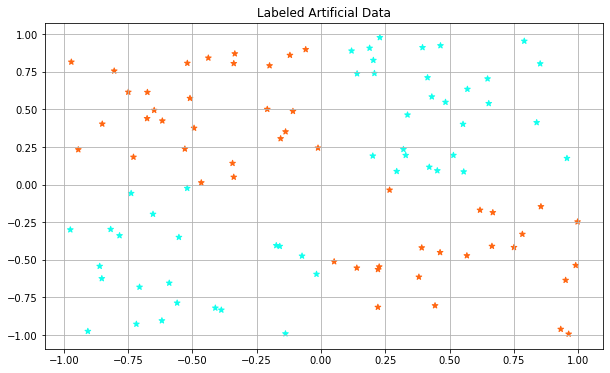

In [9]:
[x_train,x_valid,x_test,y_train,y_valid,y_test]=\
[[] for i in range(6)]
%make_XOR 1000
features=[tf.feature_column.numeric_column(
          key='input-features:',shape=(2,))]
%display_data test

In [10]:
dhtml('Built Keras Models as Estimators')

In [11]:
model=tf.keras.Sequential([
    tkl.Input(shape=(2,),name='input-features'),
    tkl.Dense(units=4,activation='relu'),
    tkl.Dense(units=4,activation='relu'),
    tkl.Dense(units=4,activation='relu'),
    tkl.Dense(1,activation='sigmoid',name='out')])
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
tfe=tf.keras.estimator.model_to_estimator(
    keras_model=model,
    model_dir='models/estimator-for-XOR/')

In [12]:
dhtml('Training')

In [13]:
print(model.summary())
print(tfe.config.session_config)
%train_valid 200 8

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
out (Dense)                  (None, 1)                 5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________
None
allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}



In [14]:
dhtml('Evaluation')

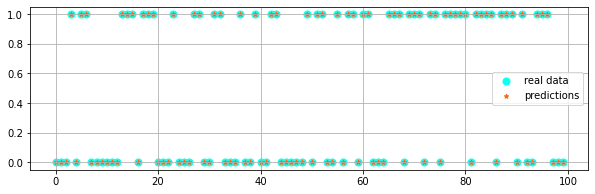

In [15]:
batch_size=8
test_result=tfe\
.evaluate(input_fn=lambda:\
          test_input_fn(x_test,y_test,batch_size))
y_test_pred=tfe\
.predict(input_fn=lambda:\
         test_input_fn(x_test,y_test,batch_size))
py_test=[]
for i in range(len(y_test)):
    py_test.append(round(next(iter(y_test_pred))['out'][0]))
phtml(test_result)
%display_predictions test